In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm import tqdm

import os

import torch
from torch import optim
from torchvision import  transforms

from sklearn.model_selection import ParameterGrid

from lib.classifier import *
from lib.utils import *
from lib.models import LeNet_5_AVG
from lib.task import load_data

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-25 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 87%


In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True

In [3]:
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [4]:
param_grid = {    
    'EXPERIMENT'                    : ['LeNet_5_AVG'],
    'TIMESTAMP'                     : ['0_0_0_0'] ,

    'ROOT_DIR'                      : ['data'],
    
    'MODEL'                         : [LeNet_5_AVG],

    'NUM_WORKERS'                   : [2],

    'NUM_EPOCHS'                    : [100],

    'BATCH_SIZE'                    : [86],
    
    'HIDDEN_SIZE'                   : [256],
    'DROPOUT'                       : [0.25],
    'INITIALIZE'                    : [torch_weight_init],

    'LR'                            : [0.08],
    'MOMENTUM'                      : [0.9],
    'WEIGHT_DECAY'                  : [5e-4],
    'NESTROV'                       : [True],

    'LR_LAMBDA'                     : [
                                        lambda epoch : max( math.pow(0.78, math.floor((1 + epoch) / 4.0)), 0.01),
                                        ],

    'STOPPING_PATIENCE'             : [40],

    'USE_CUDA'                      : [torch.cuda.is_available()],

    'CHECKPOINT_INTERVAL'           : [105],
    'CHECKPOINT_RESTORE'            : [False],

    'USE_CUDA'                      : [torch.cuda.is_available()],
    
    'SEED'                          : [0]
}
print("Number of evaluations:", len(list(ParameterGrid(param_grid))))

Number of evaluations: 1


In [5]:
import os
from datetime import datetime
import shutil

experiment_name = param_grid['EXPERIMENT'][0].strip() 
root_dir = param_grid['ROOT_DIR'][0].strip()

if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

MNIST(root_dir, dataset="train", download=True)

path = os.path.join(experiment_name, root_dir )
shutil.copytree(root_dir, path)

'LeNet_5_AVG/data'

In [6]:
import subprocess
import time

print("Processes to start:", len(ParameterGrid(param_grid)))

results = []
num_procs = 5
for param_batch in batch(np.array(ParameterGrid(param_grid)), num_procs):
    
    processes = []
    for param in param_batch:
        timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S_%f')

        h = HYPERPARAMETERS(param)
        h.TIMESTAMP = timestamp
        HYPERPARAMETERS.dump(h, os.path.join(experiment_name, "HP_" + timestamp + ".pkl" ))

        p = subprocess.Popen(["python", "task.py", "-e "+experiment_name, "-t "+timestamp], stdout=subprocess.PIPE)
        processes.append((p, timestamp))
    
    pcount = len(processes)
    pfinished = 0
    while pfinished < pcount:

        for i, (p, timestamp) in enumerate(processes):
            if p.poll() is not None:
                ret = p.communicate()
                results.append((p, timestamp, ret))
                del processes[i]
                pfinished += 1
                break

        time.sleep(0.1)    

print("Processes finished:", len(results))

Processes to start: 1
Processes finished: 1


In [7]:
import glob

timestamps = [os.path.splitext(os.path.basename(f))[0][3:] for f in glob.glob( './' + experiment_name + '/HP_*.pkl' )]
timestamps

['2018_09_25_18_16_28_376780']

In [8]:
valid_scores=[]
for i, timestamp in enumerate(timestamps):
    print("Experiment: ", i, " - ", timestamp, " - ", end='')
    
    h = HYPERPARAMETERS.load(os.path.join(experiment_name, "HP_" + timestamp + ".pkl" ))
    
    model = h.MODEL(D_in=(1, 28, 28), D_out=10, H=h.HIDDEN_SIZE, dropout=h.DROPOUT, initialize=h.INITIALIZE)
    
    try:
        chkpt_file = Checkpoint(model, root_dir=h.EXPERIMENT, experiment_dir=h.TIMESTAMP).last()
        state = torch.load(chkpt_file)
    except:
        print(' failed')
        continue
    
    stopping = Stopping(model)
    stopping.load_state_dict(state['stopping'])
    model.load_state_dict(stopping.best_score_state) 
    epoch = int(str(stopping).split(' ')[-1])
    print(epoch , h.LR, " - ", end='')

    m = Metric([])
    m.load_state_dict(state['metrics'])
    test_score = m.values['train_score'][epoch-1]
    valid_score = m.values['valid_score'][epoch-1]
    valid_scores.append(valid_score)
    
    print(test_score, valid_score)

Experiment:  0  -  2018_09_25_18_16_28_376780  - 51 0.08  - 0.9999400623351714 0.9963227986483805


In [9]:
import glob

timestamps = [os.path.splitext(os.path.basename(f))[0][3:] for f in glob.glob( './' + experiment_name + '/HP_*.pkl' )]
timestamps

['2018_09_25_18_16_28_376780']

In [10]:
valid_scores=[]
for i, timestamp in enumerate(timestamps):
    print("Experiment: ", i, " - ", timestamp, " - ", end='')
    
    h = HYPERPARAMETERS.load(os.path.join(experiment_name, "HP_" + timestamp + ".pkl" ))
    
    model = h.MODEL(D_in=(1, 28, 28), D_out=10, H=h.HIDDEN_SIZE, dropout=h.DROPOUT, initialize=h.INITIALIZE)
    
    try:
        chkpt_file = Checkpoint(model, root_dir=h.EXPERIMENT, experiment_dir=h.TIMESTAMP).last()
        state = torch.load(chkpt_file)
    except:
        print(' failed')
        continue
    
    stopping = Stopping(model)
    stopping.load_state_dict(state['stopping'])
    model.load_state_dict(stopping.best_score_state) 
    epoch = int(str(stopping).split(' ')[-1])
    print(epoch , h.LR, " - ", end='')

    m = Metric([])
    m.load_state_dict(state['metrics'])
    test_score = m.values['train_score'][epoch-1]
    valid_score = m.values['valid_score'][epoch-1]
    valid_scores.append(valid_score)
    
    print(test_score, valid_score)

Experiment:  0  -  2018_09_25_18_16_28_376780  - 51 0.08  - 0.9999400623351714 0.9963227986483805


In [11]:
sorted(range(len(valid_scores)), key=valid_scores.__getitem__)

[0]

In [12]:
experiment_name = param_grid['EXPERIMENT'][0]

timestamp = timestamps[sorted(range(len(valid_scores)), key=valid_scores.__getitem__)[-1]]

experiment_name, timestamp

('LeNet_5_AVG', '2018_09_25_18_16_28_376780')

In [13]:
H = HYPERPARAMETERS.load(os.path.join(experiment_name, "HP_" + timestamp + ".pkl" ))
print(H)

{
    'WEIGHT_DECAY'                  : 0.0005 ,
    'USE_CUDA'                      : True ,
    'TIMESTAMP'                     : '2018_09_25_18_16_28_376780' ,
    'STOPPING_PATIENCE'             : 40 ,
    'SEED'                          : 0 ,
    'ROOT_DIR'                      : 'data' ,
    'NUM_WORKERS'                   : 2 ,
    'NUM_EPOCHS'                    : 100 ,
    'NESTROV'                       : True ,
    'MOMENTUM'                      : 0.9 ,
    'MODEL'                         : LeNet_5_AVG ,
                                        lambda epoch : max( math.pow(0.78, math.floor((1 + epoch) / 4.0)), 0.01),
    'LR'                            : 0.08 ,
    'INITIALIZE'                    : torch_weight_init ,
    'HIDDEN_SIZE'                   : 256 ,
    'EXPERIMENT'                    : 'LeNet_5_AVG' ,
    'DROPOUT'                       : 0.25 ,
    'CHECKPOINT_RESTORE'            : False ,
    'CHECKPOINT_INTERVAL'           : 105 ,
    'BATCH_SIZE'            

In [14]:
model = H.MODEL(D_in=(1, 28, 28), D_out=10, H=H.HIDDEN_SIZE, dropout=H.DROPOUT, initialize=H.INITIALIZE)

chkpt_file = Checkpoint(model, root_dir=H.EXPERIMENT, experiment_dir=H.TIMESTAMP).last()
state = torch.load(chkpt_file)

In [15]:
m = Metric([])
m.load_state_dict(state['metrics'])

In [16]:
stopping = Stopping(model)
stopping.load_state_dict(state['stopping'])

model.load_state_dict(stopping.best_score_state)

In [17]:
# torch.save(model.state_dict(), './LeNet_5_AVG.tar')

Best epoch: 51, score 0.996323
{
    'WEIGHT_DECAY'                  : 0.0005 ,
    'USE_CUDA'                      : True ,
    'TIMESTAMP'                     : '2018_09_25_18_16_28_376780' ,
    'STOPPING_PATIENCE'             : 40 ,
    'SEED'                          : 0 ,
    'ROOT_DIR'                      : 'data' ,
    'NUM_WORKERS'                   : 2 ,
    'NUM_EPOCHS'                    : 100 ,
    'NESTROV'                       : True ,
    'MOMENTUM'                      : 0.9 ,
    'MODEL'                         : LeNet_5_AVG ,
                                        lambda epoch : max( math.pow(0.78, math.floor((1 + epoch) / 4.0)), 0.01),
    'LR'                            : 0.08 ,
    'INITIALIZE'                    : torch_weight_init ,
    'HIDDEN_SIZE'                   : 256 ,
    'EXPERIMENT'                    : 'LeNet_5_AVG' ,
    'DROPOUT'                       : 0.25 ,
    'CHECKPOINT_RESTORE'            : False ,
    'CHECKPOINT_INTERVAL'           : 105

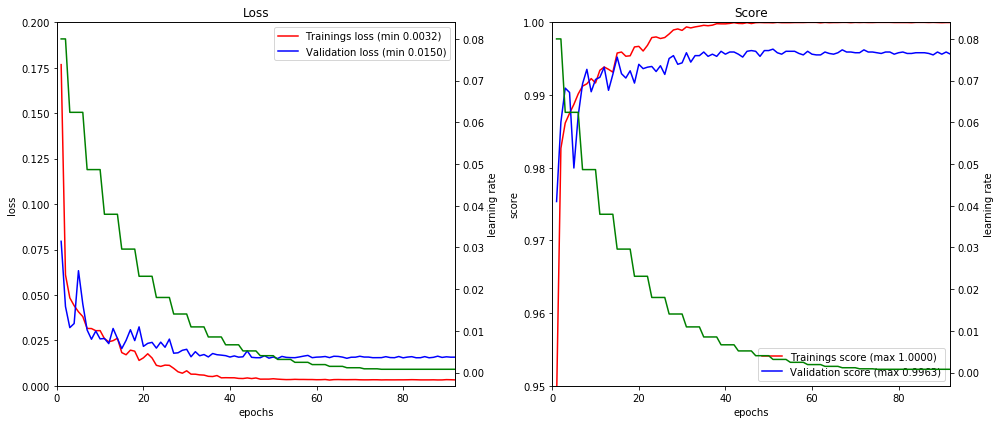

In [18]:
print("Best epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))

print(H)
print(stopping)
plot_learning_curves(m, (0, 0.2), (0.95, 1.0))

In [19]:
np.random.seed(H.SEED)
torch.manual_seed(H.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(H.SEED)

In [20]:
print_model_summary(model)

Summary for model: LeNet_5_AVG
_________________________________________________________________
Layer (type)                 Shape                     Param #   
conv1.0 (Conv2d)             ((32, 1, 5, 5),)          800       
_________________________________________________________________
conv1.1 (BatchNorm2d)        ((32,), (32,))            64        
_________________________________________________________________
conv1.2 (ReLU)               ()                        0         
_________________________________________________________________
conv1.3 (Conv2d)             ((32, 32, 5, 5),)         25600     
_________________________________________________________________
conv1.4 (BatchNorm2d)        ((32,), (32,))            64        
_________________________________________________________________
conv1.5 (MaxPool2d)          ()                        0         
_________________________________________________________________
conv1.6 (ReLU)               ()              

In [21]:
train_loader, valid_loader, test_loader, target_names = load_data(H)

In [22]:
criterion = nn.CrossEntropyLoss()
scorer = Scorer()

train_evaluator = Evaluator(model, train_loader, criterion, scorer)
valid_evaluator = Evaluator(model, valid_loader, criterion, scorer)
test_evaluator = Evaluator(model, test_loader, criterion, scorer)

_, train_score = train_evaluator()
_, valid_score = valid_evaluator()
_, test_score = test_evaluator()

print("Train/Valid/Test:", train_score, valid_score, test_score)

Train/Valid/Test: 1.0 0.9963227986483805 0.9965215662890085


In [23]:
print("Train/Valid:", m.values['train_score'][26], m.values['valid_score'][26])

Train/Valid: 0.998401662271238 0.9950308089842977


In [24]:
y_test = []
for _, target_vars in test_loader:
    y_test.extend( to_np( target_vars) )
y_test = np.array(y_test)

y_pred, y_probas = Recognizer(model, test_loader)()

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))
print('Accuracy     ', metrics.accuracy_score(y_test, y_pred) * 100)
print('Recall       ', metrics.recall_score(y_test, y_pred, average='macro') * 100)
print('Precision    ', metrics.precision_score(y_test, y_pred, average='macro') * 100)
print('F1           ', metrics.f1_score(y_test, y_pred, average='macro') * 100)
print('Error rate(%)', (np.sum(y_test != y_pred)/y_test.shape[0]) * 100)

Confusion Matrix
 [[ 979    0    0    0    0    0    1    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    0 1029    1    0    0    0    1    1    0]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    0    0    0  978    0    0    0    1    3]
 [   0    0    0    3    0  887    1    1    0    0]
 [   2    1    0    0    0    2  952    0    1    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   0    0    1    0    0    1    0    1  970    1]
 [   0    0    0    0    5    1    0    0    0 1003]]
Accuracy      99.65
Recall        99.64206359705153
Precision     99.6458711138669
F1            99.64387354515594
Error rate(%) 0.35000000000000003


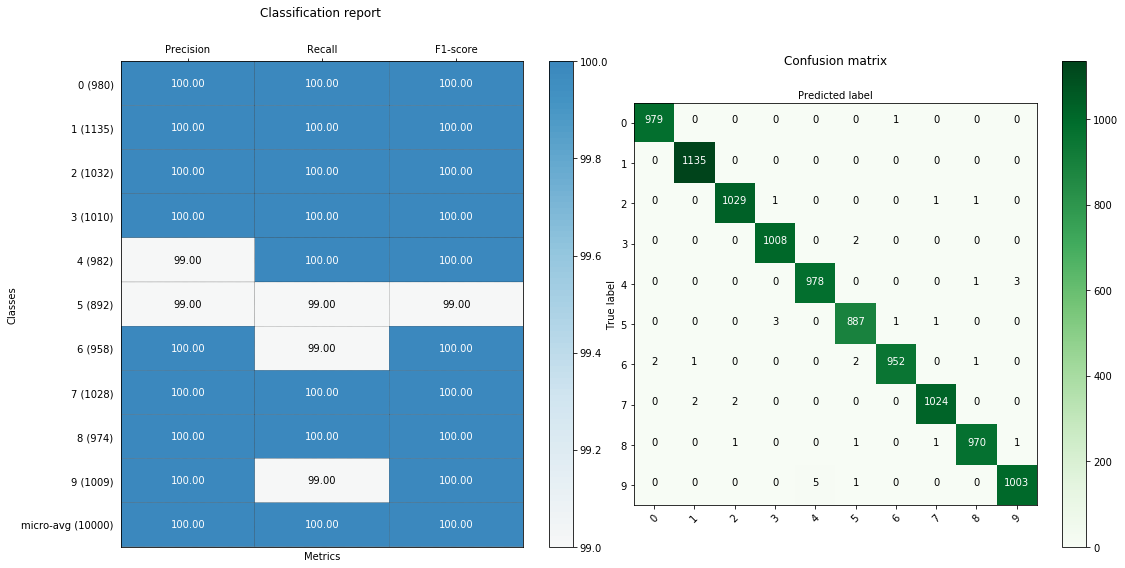

In [25]:
plot_classifier_summary(y_test, y_pred, target_names, figsize=(16,8))

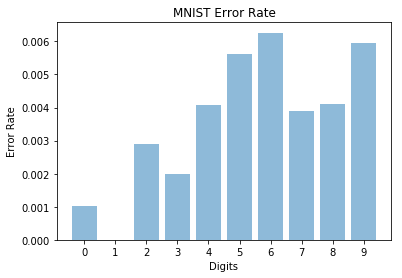

In [26]:
bad_image_indices = np.where(y_test != y_pred)[0]

bad_label_count = Counter(y_test[bad_image_indices])
a = np.array([[k,float(bad_label_count[k])/v] for k,v in Counter(y_test).items() if k in bad_label_count])

plt.bar(a[:,0], a[:,1], align='center', alpha=0.5)
plt.xticks(range(10), range(10))
plt.ylabel('Error Rate' )
plt.xlabel('Digits')
plt.title('MNIST Error Rate');

Bad Images: 35


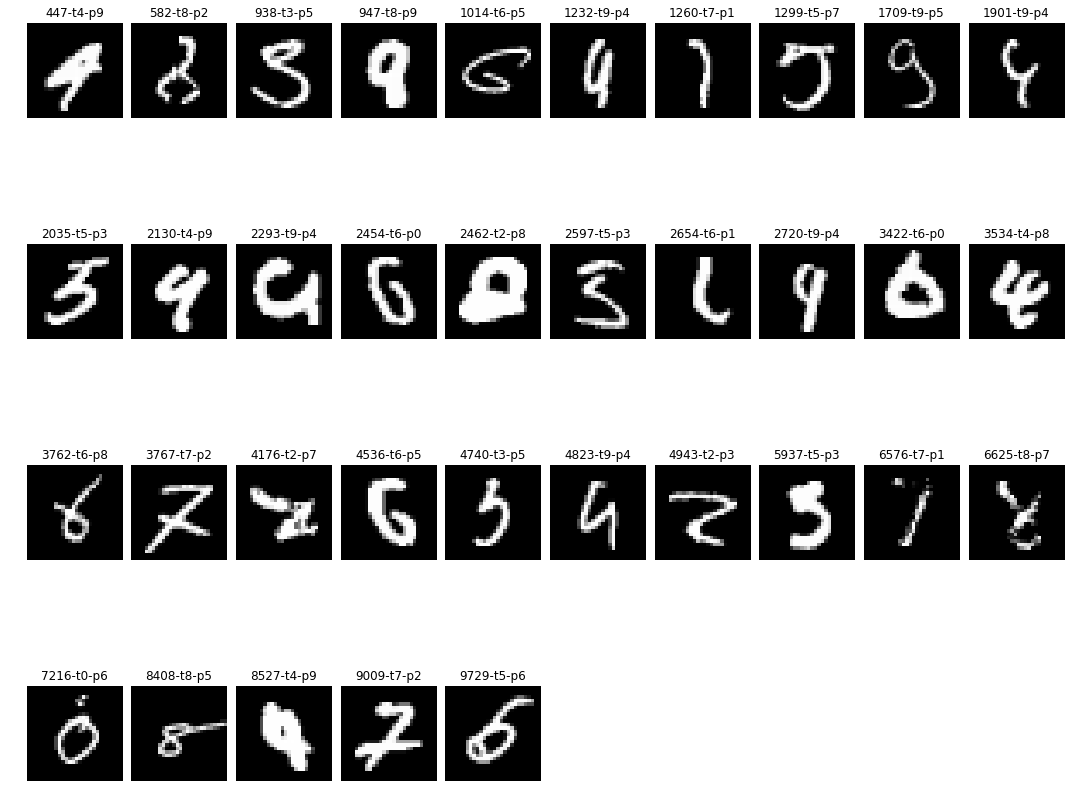

In [27]:
import matplotlib.gridspec as gridspec

X_test = []
for input_vars, _ in test_loader:
    X_test.extend( to_np( input_vars) )
X_test = np.array(X_test)


bad_image_indices = np.where(y_test != y_pred)[0]

n = len(bad_image_indices)

print("Bad Images:", n)

if n < 100:
    bad_images = X_test[bad_image_indices]
    bad_labels = y_pred[bad_image_indices]
    good_labels = y_test[bad_image_indices]

    plt.figure(figsize = (18, 12))

    gs = gridspec.GridSpec(n//10+1, 10)

    gs.update(wspace=0.1, hspace=0.1, left = 0.1, right = 0.9, bottom = 0.1, top = 1.1) 

    for idx, (img, blb, glb) in enumerate(zip(bad_images, bad_labels, good_labels)):
        ax = plt.subplot(gs[idx])
        plt.axis('off')
        ax.imshow(img.reshape(28,28), cmap = matplotlib.cm.gray)
        ax.set_title(str(bad_image_indices[idx]) + "-t" + str(int(glb)) + "-p" + str(blb))
        ax.set_aspect('equal')

else:
    print("Too many images, can't plot.")

In [28]:
print_model_summary(model)

Summary for model: LeNet_5_AVG
_________________________________________________________________
Layer (type)                 Shape                     Param #   
conv1.0 (Conv2d)             ((32, 1, 5, 5),)          800       
_________________________________________________________________
conv1.1 (BatchNorm2d)        ((32,), (32,))            64        
_________________________________________________________________
conv1.2 (ReLU)               ()                        0         
_________________________________________________________________
conv1.3 (Conv2d)             ((32, 32, 5, 5),)         25600     
_________________________________________________________________
conv1.4 (BatchNorm2d)        ((32,), (32,))            64        
_________________________________________________________________
conv1.5 (MaxPool2d)          ()                        0         
_________________________________________________________________
conv1.6 (ReLU)               ()              

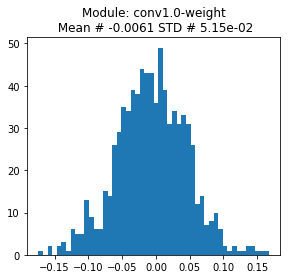

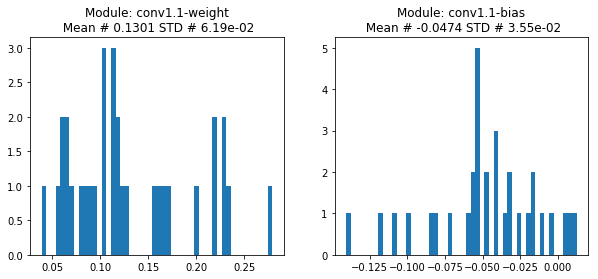

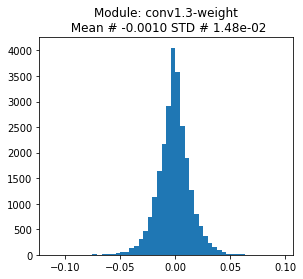

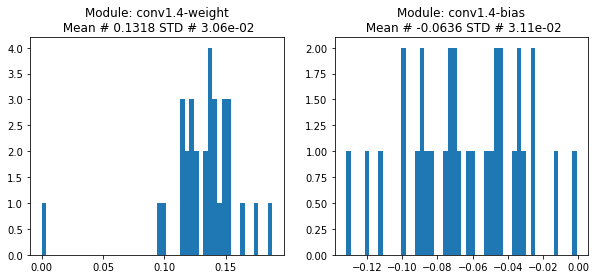

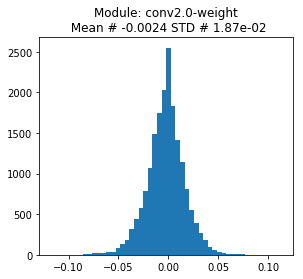

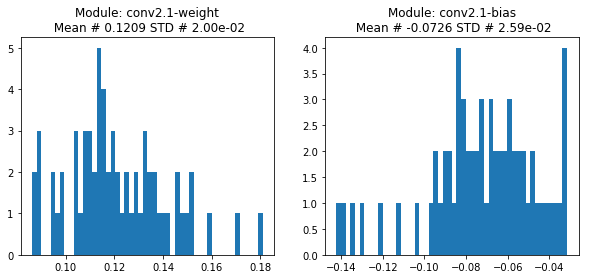

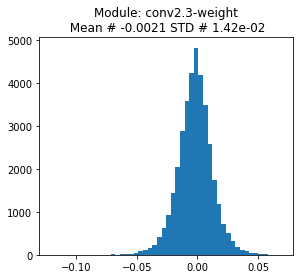

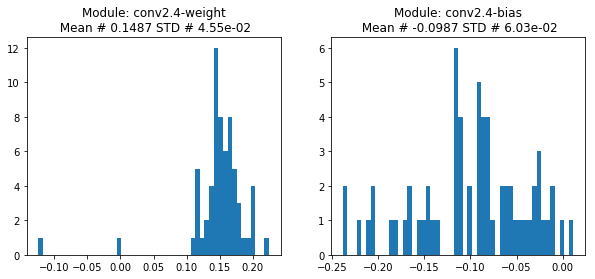

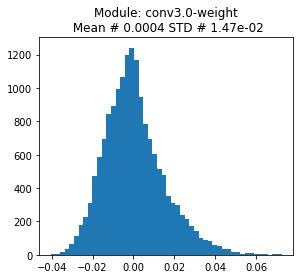

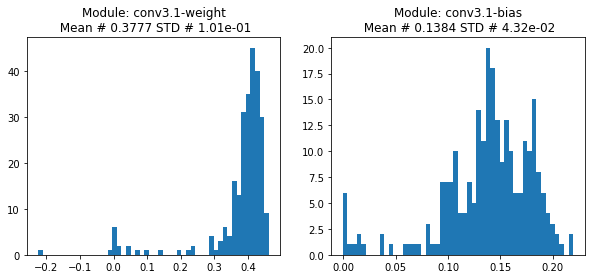

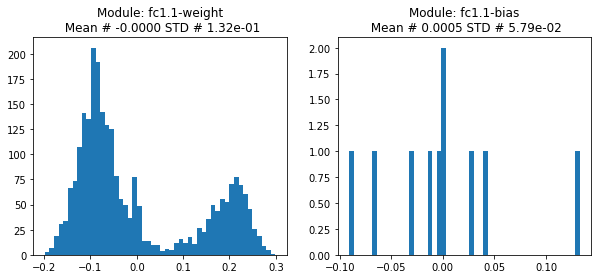

In [29]:
plot_layer_stats(model)

In [30]:
plot_model_graph(module(Variable(torch.FloatTensor(2, 28, 28).zero_())), model.state_dict())

NameError: name 'module' is not defined